In [1]:
import sys
sys.path.insert(0, "./mmdetection")

import os
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check MMDetection installation
from mmdet.apis import set_random_seed

# Imports
from mmdet.apis import set_random_seed

import mmcv
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
from mmdet.datasets import build_dataloader, build_dataset
from mmdet.apis import single_gpu_test
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import cv2
import json
import random
import numpy as np

1.7.0 True
11.0
GCC 7.3


In [15]:
global_seed = 111

def set_seed(seed=global_seed):
    """Sets the random seeds."""
    set_random_seed(seed, deterministic=False)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [16]:
from mmcv import Config

cfg_path = f'models/detector-cascadercnn/job4_cascade_rcnn_x101_32x4d_fpn_1x_coco.py'
model_checkpoint = "models/detector-cascadercnn/epoch_10.pth"

print("Loading weights from:", model_checkpoint)
cfg = Config.fromfile(cfg_path)
model = init_detector(cfg, model_checkpoint, device='cuda:0')

Loading weights from: models/detector-cascadercnn/epoch_10.pth
load checkpoint from local path: models/detector-cascadercnn/epoch_10.pth


/workspace/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [44]:
with open("./dataset/covid19-coco-512-GroupKFold/val_annotations_fold0.json") as f:
    val_ann = json.load(f)
imagepaths = {item["id"]:item['file_name'] for item in val_ann['images'][:9]}

df_annotations = pd.read_csv('./dataset/resized-512/df_train_processed_meta.csv')
df_annotations = df_annotations.rename(columns={"width":"dim0", 'height':"dim1"})

In [34]:
imagepaths

{0: '001bd15d1891_image.png',
 1: '0022227f5adf_image.png',
 2: '004cbd797cd1_image.png',
 3: '008ff73b4ef3_image.png',
 4: '00fb65888ddf_image.png',
 5: '01376c1ba556_image.png',
 6: '02037e3e6555_image.png',
 7: '0283ed37496d_image.png',
 8: '02d302d64d58_image.png'}

In [35]:
df_annotations[df_annotations["id"] == imagepaths[0].replace(".png", "")]

,id,StudyInstanceUID,folder_id,study_id,dim1,dim2,xmin,ymin,xmax,ymax
5,001bd15d1891_image,dfd9fdd85a3e,49170afa4f27,dfd9fdd85a3e,2800,3408,94,192,201,394
6,001bd15d1891_image,dfd9fdd85a3e,49170afa4f27,dfd9fdd85a3e,2800,3408,387,183,487,387


In [36]:
df_annotations.columns

Index(['id', 'StudyInstanceUID', 'folder_id', 'study_id', 'dim1', 'dim2',
       'xmin', 'ymin', 'xmax', 'ymax'],
      dtype='object')

In [10]:
imagepaths[0]

'001bd15d1891_image.png'

In [71]:
from rebox import BBox
from rebox.formats import coco, pascal


annotations = {}
for item in val_ann["annotations"]:
    if item["image_id"] in imagepaths.keys():
        bbox = BBox(item["bbox"], coco).as_format(pascal).value.tolist()
        try:
            annotations[item["image_id"]].append(bbox)
        except KeyError:
            annotations[item["image_id"]] = [bbox]

In [72]:
annotations[0]

[[94, 192, 201, 394], [387, 183, 487, 387]]

In [73]:
len(annotations[3])

2

In [74]:
def draw_bbox(image,
              box,
              label,
              color,
              label_size = 0.5,
              alpha_box = 0.3,
              alpha_label = 0.6):
    
    overlay_bbox = image.copy()
    overlay_label = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(),
                                              cv2.FONT_HERSHEY_SIMPLEX, label_size, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                  color, -1)
    cv2.addWeighted(overlay_bbox, alpha_box, output, 1-alpha_box, 0, output)
    
    cv2.rectangle(overlay_label, (box[0], box[1]-7-text_height),
                  (box[0]+text_width+2, box[1]), (0, 0, 0), -1)
    cv2.addWeighted(overlay_label, alpha_label, output, 1-alpha_label, 0, output)
    output = cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                           color, 2)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, label_size, (255, 255, 255), 1, cv2.LINE_AA)
    return output

In [75]:
512 / df_annotations[df_annotations["id"] == imagepaths[0].replace(".png", "")].head(1).dim0

5    0.182857
Name: dim0, dtype: float64

In [76]:
annotations[0][0][0] * 0.182857

17.188558

[[94, 192, 201, 394], [387, 183, 487, 387]]
[[312, 103, 375, 183]]
[[88, 200, 236, 404], [277, 192, 428, 411]]
[[73, 109, 212, 364], [349, 134, 459, 400]]
[[102, 99, 217, 298], [346, 132, 452, 299]]
[[84, 157, 212, 348], [265, 111, 398, 265]]
[[120, 69, 268, 281], [303, 79, 424, 326]]
[[30, 286, 211, 403], [276, 265, 420, 385]]
[[122, 83, 196, 234], [354, 80, 436, 258]]


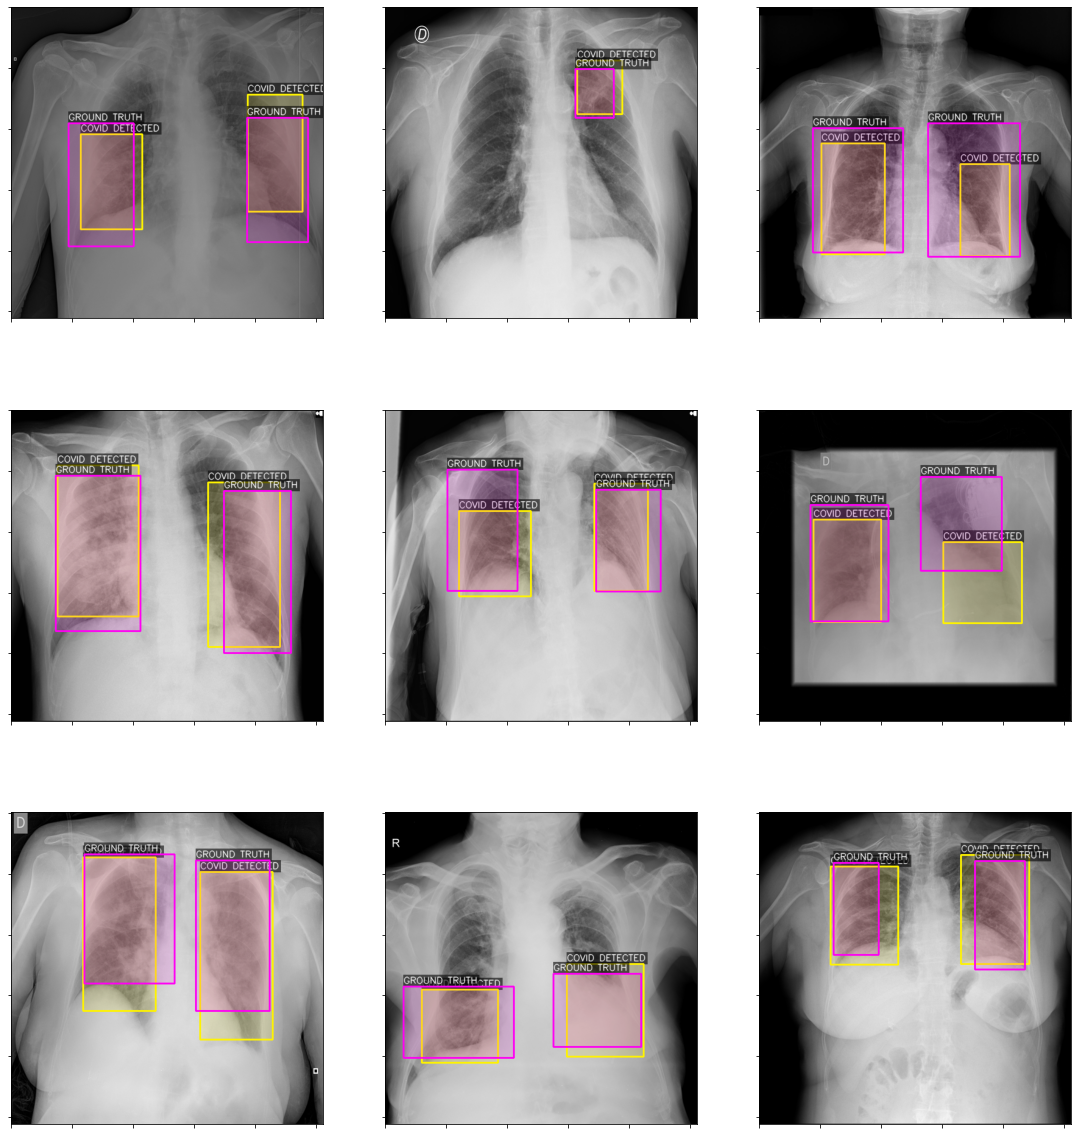

In [80]:
from utils import scale_bbox

new_size = (512, 512)
imgs_path = "./dataset/resized-512/train"
threshold = 0.45

fig, axes = plt.subplots(3,3, figsize=(19,21))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axes = axes.ravel()

results_list = []

for idx, (image_id, filename)  in enumerate(imagepaths.items()):
    img_path = os.path.join(imgs_path, filename)
    img = cv2.imread(img_path)
    result = inference_detector(model, img_path)
    results_filtered = result[0][result[0][:, 4]>threshold]
    bboxes = results_filtered[:, :4]
    scores = results_filtered[:, 4] 
    results_list.append(result[0])
    
    for box in bboxes:
        img = draw_bbox(img, list(np.int_(box)), "Covid Detected",
                        (255, 243, 0))
    
    # gt_bboxes = scale_bbox(512, df_annotations[df_annotations["id"] == filename.replace(".png", "")].head(1), annotations[image_id])
    gt_bboxes = annotations[image_id]
    for gt_box in gt_bboxes:
        img = draw_bbox(img, list(np.int_(gt_box)), "Ground Truth",
                        (255, 0, 243))
    print(gt_bboxes)

    axes[idx].imshow(img, cmap='gray')
    # axes[idx].set_title(img_id, size=18, pad=30)
    axes[idx].set_xticklabels([])
    axes[idx].set_yticklabels([])

In [92]:
len(val_ann["images"])

858

In [97]:
val_ann["annotations"][8]

{'id': 8,
 'image_id': 4,
 'category_id': 0,
 'area': 17702,
 'bbox': [346, 132, 106, 167],
 'iscrowd': 0}

In [99]:
new_size = (512, 512)
imgs_path = "./dataset/resized-512/train"
threshold = 0.45

detections = []
idx = 0

for image in val_ann["images"]:
    img_path = os.path.join(imgs_path, image['file_name'])
    img = cv2.imread(img_path)
    result = inference_detector(model, img_path)
    results_filtered = result[0][result[0][:, 4]>threshold]
    bboxes = results_filtered[:, :4]
    scores = results_filtered[:, 4]

    for bbox, score in zip(bboxes, scores):
        bbox = BBox(bbox, pascal).as_format(coco).value
        detection = {
            "id": idx,
            "area": bbox[2] * bbox[3],
            "image_id": image["id"],
            "bbox": bbox.astype(np.int32).tolist() ,
            "iscrowd": 0,
            "score": float(score),
            "category_id" : 0
        }
        detections.append(detection)
        idx += 1
    

In [100]:
test_det = {
    "images": val_ann["images"],
    "annotations": detections,
    "categories":val_ann["categories"]
}

In [101]:
len(test_det["annotations"])

1660

In [102]:
test_det["annotations"][0]

{'id': 0,
 'area': 17105.94,
 'image_id': 0,
 'bbox': [388, 145, 89, 191],
 'iscrowd': 0,
 'score': 0.7773832082748413,
 'category_id': 0}

In [103]:
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

with open("output/covid-test-det/covid-19-test-det.json", "w") as fp:
    json.dump(test_det, fp, cls=JSONEncoder)

with open("output/covid-test-gts/covid-19-test-gt.json", "w") as fp:
    json.dump(val_ann, fp, cls=JSONEncoder)

# Result

```
COCO METRICS:
AP: 0.1506856500798415
AP50: 0.4565885062438053
AP75: 0.058548339165218
APsmall: 0.0
APmedium: 0.0368959715563841
APlarge: 0.18093391873910716
AR1: 0.13303628262253342
AR10: 0.23863781031190326
AR100: 0.23863781031190326
ARsmall: 0.0
ARmedium: 0.048881789137380185
ARlarge: 0.2879103282626101

PASCAL METRIC (AP per class)
Covid_Abnormality: 0.5201428573519917

PASCAL METRIC (mAP)
mAP: 0.5201428573519917
```